# Extract metadata information from PubMed

Utilize the [Bio.Entrez package](https://biopython.org/docs/latest/api/Bio.Entrez.html) to get metadata for PubMed articles.

### Import packages

In [1]:
import pandas as pd
from collections import defaultdict

from rbc_gem_utils import (
    ROOT_PATH,
    EXTERNAL_PATH,
    DATABASE_PATH,
    RESULTS_PATH,
    GEM_NAME,
    read_rbc_model,
    get_annotation_df,
    show_versions,
    split_string,
)

from rbc_gem_utils.database.pubmed import (
    fetch_batch_results_PubMed,
    get_mesh_terms,
    get_value_PubMed,
    search_erythrocyte_keywords_PubMed,
    PUBMED_ERYTHROCYTE_KEYWORDS,
)
from rbc_gem_utils.util import build_string

show_versions()


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
-------------------

## Load RBC-GEM model

In [2]:
model = read_rbc_model("xml")
model

Name,RBC_GEM
Memory address,14fe43a10
Number of metabolites,1984
Number of reactions,2823
Number of genes,693
Number of groups,76
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


## Download meta data from PubMed
### Get IDs for query from model

In [3]:
model_pmids = set()
model_dois = set()
model_other = set()
annotation_key = "references"

for attribute_type in ["reactions", "metabolites", "genes"]:
    df = get_annotation_df(getattr(model, attribute_type), annotation_key)
    df = df[annotation_key].fillna("").apply(split_string).explode()
    references = df[df != ""].unique()
    pmids = set(
        [x.replace("pubmed:", "") for x in references if x.startswith("pubmed")]
    )
    dois = set([x for x in references if x.startswith("doi")])
    other = set(
        [x for x in references if not (x.startswith("pubmed") or x.startswith("doi"))]
    )
    print(f"From model {attribute_type}\n" + len(f"From model {attribute_type}") * "-")
    print(f"Number of PubMed IDs: {len(pmids)}")
    print(f"Number of DOI links: {len(dois)}")
    print(f"Number of other IDs: {len(other)}")
    print()
    model_pmids.update(pmids)
    model_dois.update(dois)
    model_other.update(other)
print(f"Number of unique PubMed IDs from model in total: {len(model_pmids)}")
print(f"Number of unique PubMed IDs from model in total: {len(model_dois)}")
print(f"Number of unique PubMed IDs from model in total: {len(model_other)}")

From model reactions
--------------------
Number of PubMed IDs: 902
Number of DOI links: 9
Number of other IDs: 0

From model metabolites
----------------------
Number of PubMed IDs: 0
Number of DOI links: 0
Number of other IDs: 0

From model genes
----------------
Number of PubMed IDs: 615
Number of DOI links: 8
Number of other IDs: 0

Number of unique PubMed IDs from model in total: 1211
Number of unique PubMed IDs from model in total: 13
Number of unique PubMed IDs from model in total: 0


/Users/zhaiman/opt/github/RBC-GEM/code/src/rbc_gem_utils/annotation.py:115: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace("", float("nan"))


### Get IDs for query from omic data

In [4]:
proteomic_pmids = set()

In [5]:
df_proteomic_evidence = pd.read_csv(
    f"{ROOT_PATH}{EXTERNAL_PATH}/proteomics/proteomic_evidence_table.tsv",
    sep="\t",
    index_col=0,
)
proteomic_pmids = set(
    [
        x.replace("pubmed:", "") if x.startswith("pubmed") else x
        for x in set(df_proteomic_evidence.columns)
    ]
)
print(f"Number of unique PubMed IDs from proteomics: {len(proteomic_pmids)}")
proteomic_pmids;

Number of unique PubMed IDs from proteomics: 27


#### Combine PubMed IDs from all sources for query

In [6]:
query_ids = set()
print(f"Number of unique PubMed IDs\n===========================")
print(f"Extracted from model: {len(model_pmids)}")
print(f"Proteomic data: {len(proteomic_pmids)}")

for pmids in [model_pmids, proteomic_pmids]:
    query_ids.update(pmids)
query_ids = sorted(query_ids)

print(f"\nTotal number of unique PubMed IDs (additional): {len(query_ids)}")

Number of unique PubMed IDs
Extracted from model: 1211
Proteomic data: 27

Total number of unique PubMed IDs (additional): 1222


### Get results from pubmed

In [7]:
only_major = True  # Refers to mesh headings
overwrite = True
imagetype = "png"
transparent = False
# Make sure to use your email
email = "zhaiman@ucsd.edu"
# email = "USERNAME"

In [8]:
all_results, failed_ids = fetch_batch_results_PubMed(
    email=email,
    pubmed_ids=query_ids,
    batch_size=500,
    return_failed=True,
)
if failed_ids:
    print(failed_ids)

Fetching results for batch 1  (500/1222)
Fetching results for batch 2  (1000/1222)
Fetching results for batch 3  (1222/1222)


### Create DataFrame from results

In [9]:
data = defaultdict(dict)
for idx, result in enumerate(all_results):
    medline_citation = result["MedlineCitation"]

    article = medline_citation["Article"]
    data[idx]["#"] = idx
    data[idx]["PubMed ID"] = get_value_PubMed(medline_citation, "PMID")

    data[idx]["Article/Section Title"] = get_value_PubMed(article, "ArticleTitle")
    data[idx]["Abstract"] = get_value_PubMed(article, "Abstract", "AbstractText")
    data[idx]["Language"] = get_value_PubMed(article, "Language", 0)
    data[idx]["Start Page"] = get_value_PubMed(article, "Pagination", "StartPage")
    data[idx]["End Page"] = get_value_PubMed(article, "Pagination", "EndPage")

    journal = article["Journal"]
    data[idx]["Journal"] = get_value_PubMed(journal, "Title")

    journal_issue = journal["JournalIssue"]
    data[idx]["Volume"] = get_value_PubMed(journal_issue, "Volume")
    data[idx]["Issue"] = get_value_PubMed(journal_issue, "Issue")
    data[idx]["Year"] = get_value_PubMed(journal_issue, "PubDate", "Year")
    data[idx]["Month"] = get_value_PubMed(journal_issue, "PubDate", "Month")
    data[idx]["Day"] = get_value_PubMed(journal_issue, "PubDate", "Day")

    if medline_citation.get("MeshHeadingList", []):
        mesh_values = ([], [])
        for mesh_heading in medline_citation["MeshHeadingList"]:
            mesh_values[0].extend(
                get_mesh_terms(mesh_heading, only_major=False, use_ids=True)
            )
            mesh_values[1].extend(
                get_mesh_terms(mesh_heading, only_major=False, use_ids=False)
            )
        data[idx]["Mesh IDs"] = build_string(mesh_values[0])
        data[idx]["Mesh terms"] = build_string(mesh_values[1])

    if medline_citation.get("KeywordList", []):
        data[idx]["Keywords"] = build_string(
            [
                str(keyword)
                for keyword in medline_citation["KeywordList"][0]
                if (only_major and keyword.attributes.get("MajorTopicYN") == "Y")
                or not only_major
            ]
        )
    # Author list
    data[idx]["Authors"] = build_string(
        [
            f"{author.get('LastName')} {author.get('Initials')}"
            for author in article["AuthorList"]
        ]
    )

    # DOI
    value = article["ELocationID"]
    if value and value[0].attributes.get("EIdType") == "doi":
        data[idx]["DOI"] = str(value[0])

    # Keep track of citation type
    data[idx]["Reference type"] = "Journal, Articles"
    data[idx]["Editors"] = ""
    data[idx]["Book"] = ""
    data[idx]["Publisher"] = ""
    data[idx]["IBSN"] = ""

df_pubmed = pd.DataFrame.from_dict(data, orient="index", dtype=str).fillna("")
df_pubmed

,#,PubMed ID,Article/Section Title,Abstract,Language,Start Page,End Page,Journal,Volume,Issue,...,Mesh IDs,Mesh terms,Authors,Reference type,Editors,Book,Publisher,IBSN,DOI,Keywords
0,0,1000842,Polyamine distribution in cellular compartment...,Human blood was separated into pure preparatio...,eng,71,88,Clinica chimica acta; international journal of...,73,1,...,D000328;D001773/Q000378;D001792/Q000166;D00179...,Adult;Blood Cells/metabolism;Blood Platelets/c...,Cooper KD;Shukla JB;Rennert OM,"Journal, Articles",,,,,,
1,1,10028241,Membrane permeability of formate in human eryt...,The rate of the rapid exchange of formate medi...,eng,158,165,European biophysics journal : EBJ,28,2,...,D001639/Q000493;D002463;D004910/Q000378;D00491...,Bicarbonates/pharmacokinetics;Cell Membrane Pe...,Himmelreich U;Chapman BE;Kuchel PW,"Journal, Articles",,,,,,
2,2,10064135,Cytidine triphosphate synthase activity and mR...,Cytidine triphosphate (CTP) synthase is one of...,eng,41,46,Biological chemistry,380,1,...,D001792/Q000201;D015152;D019731/Q000096;D01973...,"Blood Platelets/enzymology;Blotting, Northern;...",Verschuur AC;Van Gennip AH;Muller EJ;Voûte PA;...,"Journal, Articles",,,,,,
3,3,10090333,Carbonic anhydrase IV activity is localized on...,Carbonic anhydrase (CA) cytoplasmic isozymes C...,eng,211,218,Acta physiologica Scandinavica,165,2,...,D000042;D000818;D015153;D002245/Q000378;D00225...,"Absorption;Animals;Blotting, Western;Carbon Di...",Wistrand PJ;Carter ND;Conroy CW;Mahieu I,"Journal, Articles",,,,,,
4,4,10192390,Transferrin receptor is necessary for developm...,Plasma iron circulates bound to transferrin (T...,eng,396,399,Nature genetics,21,4,...,D000740/Q000235;D000740/Q000473;D000818;D00462...,Anemia/genetics;Anemia/pathology;Animals;Embry...,Levy JE;Jin O;Fujiwara Y;Kuo F;Andrews NC,"Journal, Articles",,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1217,1217,977587,Formation of glutathione conjugates of prostag...,When prostaglandin A1 was incubated with a Tri...,eng,6550,6554,The Journal of biological chemistry,251,21,...,D004912/Q000378;D005978/Q000097;D006801;D01305...,Erythrocytes/metabolism;Glutathione/blood;Huma...,Cagen LM;Fales HM;Pisano JJ,"Journal, Articles",,,,,,
1218,1218,9785380,Production of prostaglandins E1 and E2 by adul...,We showed that human adult red blood cells (RB...,eng,89,101,Prostaglandins & other lipid mediators,56,2-3,...,D000328;D000527/Q000096;D015153;D002118/Q00049...,"Adult;Alprostadil/biosynthesis;Blotting, Weste...",Oonishi T;Sakashita K;Ishioka N;Suematsu N;Shi...,"Journal, Articles",,,,,,
1219,1219,9806760,The transmembrane glycoprotein CD38 is a catal...,CD38 is a type II transmembrane glycoprotein e...,eng,1507,1520,FASEB journal : official publication of the Fe...,12,14,...,D036541;D051997;D000246/Q000031;D000246/Q00037...,ADP-ribosyl Cyclase;ADP-ribosyl Cyclase 1;Aden...,Franco L;Guida L;Bruzzone S;Zocchi E;Usai C;De...,"Journal, Articles",,,,,,
1220,1220,984734,Distribution of human red cell phosphoglucomut...,,eng,103,105,Anthropologischer Anzeiger; Bericht uber die b...,35,2-3,...,D000462;D044383;D004912/Q000201;D005828;D00680...,Algeria;Black People;Erythrocytes/enzymology;G...,Berg K;Rodewald A;Schwarzfischer F;Wischerath H,"Journal, Articles",,,,,,


### Add additional references not found on PubMed
* Some references do not have an associated PubMed ID, and require manual addition.
* Some updates about erythrocyte specificity need to be made manually as they could not be detected automatically.
* Updates to PubMed references that could not be automatically be found.
* All manual additions should be formatted in the `additional_references.tsv` file to get added to the final reference table

In [10]:
df_additional = pd.read_csv(
    f"{ROOT_PATH}{DATABASE_PATH}/additional_references_manual.tsv",
    sep="\t",
    index_col=0,
    dtype=str,
).fillna("")
assert len(df_additional) == len(model_dois) + len(model_other)
df_erythrocyte = pd.concat((df_pubmed, df_additional))

column_name = "RBC Keywords"
rbc_specific_key = "RBC Specific"
df_erythrocyte[column_name] = search_erythrocyte_keywords_PubMed(
    df=df_erythrocyte,
    text_columns=[
        "Article/Section Title",
        "Abstract",
        "Mesh terms",
        "Keywords",
        "Book",
    ],
    search_keywords=PUBMED_ERYTHROCYTE_KEYWORDS,
    column_name=column_name,
)[column_name]
df_erythrocyte[rbc_specific_key] = df_erythrocyte[column_name] != ""
df_erythrocyte = df_erythrocyte.reset_index(drop=True)
df_erythrocyte

,#,PubMed ID,Article/Section Title,Abstract,Language,Start Page,End Page,Journal,Volume,Issue,...,Authors,Reference type,Editors,Book,Publisher,IBSN,DOI,Keywords,RBC Keywords,RBC Specific
0,0,1000842,Polyamine distribution in cellular compartment...,Human blood was separated into pure preparatio...,eng,71,88,Clinica chimica acta; international journal of...,73,1,...,Cooper KD;Shukla JB;Rennert OM,"Journal, Articles",,,,,,,erythrocyte;Erythrocyte,True
1,1,10028241,Membrane permeability of formate in human eryt...,The rate of the rapid exchange of formate medi...,eng,158,165,European biophysics journal : EBJ,28,2,...,Himmelreich U;Chapman BE;Kuchel PW,"Journal, Articles",,,,,,,erythrocyte;red cell,True
2,2,10064135,Cytidine triphosphate synthase activity and mR...,Cytidine triphosphate (CTP) synthase is one of...,eng,41,46,Biological chemistry,380,1,...,Verschuur AC;Van Gennip AH;Muller EJ;Voûte PA;...,"Journal, Articles",,,,,,,ERYTHRO;erythrocyte,True
3,3,10090333,Carbonic anhydrase IV activity is localized on...,Carbonic anhydrase (CA) cytoplasmic isozymes C...,eng,211,218,Acta physiologica Scandinavica,165,2,...,Wistrand PJ;Carter ND;Conroy CW;Mahieu I,"Journal, Articles",,,,,,,Erythro,True
4,4,10192390,Transferrin receptor is necessary for developm...,Plasma iron circulates bound to transferrin (T...,eng,396,399,Nature genetics,21,4,...,Levy JE;Jin O;Fujiwara Y;Kuo F;Andrews NC,"Journal, Articles",,,,,,,Erythro,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,NaN,,Human erythrocyte ammonium transport is mediat...,The ammonia/ammonium (NH3/NH4+) influx into re...,,301,310,Biochemistry (Moscow) Supplement Series A: Mem...,10,4,...,"Sudnitsyna, JS, Skvertchinskaya, EA, Dobrylko ...","Journal, Article",,,,,10.1134/S1990747816040097,,erythrocyte;RBC;red blood cell,True
1231,NaN,,Adenylosuccinate lyase from human erythrocytes,1. Adenylosuccinate lyase (S-AMP lyase) (E.C. ...,,497,503,International Journal of Biochemistry,6,7,...,"Barnes BL, Bishop SH","Journal, Article",,,,,10.1016/0020-711X(75)90030-0,,erythrocyte,True
1232,NaN,,Model Human _ Thalassemic Erythrocytes: Effect...,_ thalassemias arise from genetic defects that...,,,,,,,...,Scott MD,"Book, Section",Marwa Zakaria and Tamer Hassan,Beta Thalassemia,IntechOpen,9.78184E+12,10.5772/intechopen.90288,,RBC;Erythrocyte;red blood cell,True
1233,NaN,,Sulfiredoxin,,eng,5221,5232,,2,,...,"Zhang J, Ye Zw, Bowers RR, Townsend DM, Tew KD",Book,,Encyclopedia of Signaling Molecules,"Springer, Cham",9.78332E+12,10.1007/978-3-319-67199-4_258,,,False


In [11]:
indicies = df_erythrocyte[df_erythrocyte["PubMed ID"].isin([
    # Uses human erythrocytes
    "13416279", 
    "13654516", 
    "13563527", 
    "13654516", 
    "13800264",
    "5643703",
    "8043935",
    "9328029", 
    "10477269",
    "11428554",
    "15987364",
    
])].index
df_erythrocyte.loc[indicies, "RBC Specific"] = True
df_erythrocyte

,#,PubMed ID,Article/Section Title,Abstract,Language,Start Page,End Page,Journal,Volume,Issue,...,Authors,Reference type,Editors,Book,Publisher,IBSN,DOI,Keywords,RBC Keywords,RBC Specific
0,0,1000842,Polyamine distribution in cellular compartment...,Human blood was separated into pure preparatio...,eng,71,88,Clinica chimica acta; international journal of...,73,1,...,Cooper KD;Shukla JB;Rennert OM,"Journal, Articles",,,,,,,erythrocyte;Erythrocyte,True
1,1,10028241,Membrane permeability of formate in human eryt...,The rate of the rapid exchange of formate medi...,eng,158,165,European biophysics journal : EBJ,28,2,...,Himmelreich U;Chapman BE;Kuchel PW,"Journal, Articles",,,,,,,erythrocyte;red cell,True
2,2,10064135,Cytidine triphosphate synthase activity and mR...,Cytidine triphosphate (CTP) synthase is one of...,eng,41,46,Biological chemistry,380,1,...,Verschuur AC;Van Gennip AH;Muller EJ;Voûte PA;...,"Journal, Articles",,,,,,,ERYTHRO;erythrocyte,True
3,3,10090333,Carbonic anhydrase IV activity is localized on...,Carbonic anhydrase (CA) cytoplasmic isozymes C...,eng,211,218,Acta physiologica Scandinavica,165,2,...,Wistrand PJ;Carter ND;Conroy CW;Mahieu I,"Journal, Articles",,,,,,,Erythro,True
4,4,10192390,Transferrin receptor is necessary for developm...,Plasma iron circulates bound to transferrin (T...,eng,396,399,Nature genetics,21,4,...,Levy JE;Jin O;Fujiwara Y;Kuo F;Andrews NC,"Journal, Articles",,,,,,,Erythro,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,NaN,,Human erythrocyte ammonium transport is mediat...,The ammonia/ammonium (NH3/NH4+) influx into re...,,301,310,Biochemistry (Moscow) Supplement Series A: Mem...,10,4,...,"Sudnitsyna, JS, Skvertchinskaya, EA, Dobrylko ...","Journal, Article",,,,,10.1134/S1990747816040097,,erythrocyte;RBC;red blood cell,True
1231,NaN,,Adenylosuccinate lyase from human erythrocytes,1. Adenylosuccinate lyase (S-AMP lyase) (E.C. ...,,497,503,International Journal of Biochemistry,6,7,...,"Barnes BL, Bishop SH","Journal, Article",,,,,10.1016/0020-711X(75)90030-0,,erythrocyte,True
1232,NaN,,Model Human _ Thalassemic Erythrocytes: Effect...,_ thalassemias arise from genetic defects that...,,,,,,,...,Scott MD,"Book, Section",Marwa Zakaria and Tamer Hassan,Beta Thalassemia,IntechOpen,9.78184E+12,10.5772/intechopen.90288,,RBC;Erythrocyte;red blood cell,True
1233,NaN,,Sulfiredoxin,,eng,5221,5232,,2,,...,"Zhang J, Ye Zw, Bowers RR, Townsend DM, Tew KD",Book,,Encyclopedia of Signaling Molecules,"Springer, Cham",9.78332E+12,10.1007/978-3-319-67199-4_258,,,False


In [12]:
rbc_count = df_erythrocyte[rbc_specific_key].sum()
print(
    f"RBC specific: {rbc_count} / {len(df_erythrocyte)} ({round(rbc_count/len(df_erythrocyte), 5) * 100}%)"
)

df_erythrocyte = df_erythrocyte.sort_values(
    [rbc_specific_key, "Year", "Month", "Day"],
    ascending=[False, True, True, True],
).reset_index(drop=True)
df_erythrocyte = df_erythrocyte.drop(["#"], axis=1)
df_erythrocyte.index.name = "#"
df_erythrocyte

RBC specific: 1031 / 1235 (83.482%)


,PubMed ID,Article/Section Title,Abstract,Language,Start Page,End Page,Journal,Volume,Issue,Year,...,Authors,Reference type,Editors,Book,Publisher,IBSN,DOI,Keywords,RBC Keywords,RBC Specific
#,,,,,,,,,,,,,,,,,,,,,
0,20243383,Alkaline phosphatase in erythrocytes.,,eng,59,,Current science,16,2,1947,...,PATWARDHAN VN;RANGANATHAN S,"Journal, Articles",,,,,,BLOOD/phosphatase;ERYTHROCYTES;PHOSPHATASE/alk...,erythrocyte;ERYTHROCYTE;Erythrocyte,True
1,16748387,Crystalline human erythrocyte catalase.,,eng,203,205,The Biochemical journal,43,2,1948,...,Herbert D;Pinsent J,"Journal, Articles",,,,,,,erythrocyte;Erythrocyte,True
2,14898542,Distribution of phosphatases in human erythroc...,,eng,112,128,The Journal of physiology,116,1,1952,...,CLARKSON EM;MAIZELS M,"Journal, Articles",,,,,,ERYTHROCYTES/metabolism;PHOSPHATASES/in blood,erythrocyte;ERYTHROCYTE;Erythrocyte,True
3,13192763,Facilitated transfer of hexoses across the hum...,,eng,163,180,The Journal of physiology,125,1,1954,...,WIDDAS WF,"Journal, Articles",,,,,,ERYTHROCYTES/metabolism;FRUCTOSE/metabolism;GL...,erythrocyte;ERYTHROCYTE;Erythrocyte,True
4,13416279,Enzymatic synthesis of nicotinamide mononucleo...,,eng,759,770,The Journal of biological chemistry,225,2,1957,...,PREISS J;HANDLER P,"Journal, Articles",,,,,,NUCLEOTIDES/in blood,,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,35834009,Human cytosolic transaminases: side activities...,Transaminases play key roles in central metabo...,eng,421,,Cellular and molecular life sciences : CMLS,79,8,2022,...,Caligiore F;Zangelmi E;Vetro C;Kentache T;Dewu...,"Journal, Articles",,,,,,,,False
1231,35147247,The Mineralization Regulator ANKH Mediates Cel...,The plasma membrane protein ankylosis homologu...,eng,1024,1031,Journal of bone and mineral research : the off...,37,5,2022,...,Szeri F;Niaziorimi F;Donnelly S;Fariha N;Terty...,"Journal, Articles",,,,,10.1002/jbmr.4528,,,False
1232,36070769,ABCC1 transporter exports the immunostimulator...,The DNA sensor cyclic GMP-AMP synthase (cGAS) ...,eng,1799,1812.e4,Immunity,55,10,2022,...,Maltbaek JH;Cambier S;Snyder JM;Stetson DB,"Journal, Articles",,,,,10.1016/j.immuni.2022.08.006,,,False


### Export references

In [13]:
if overwrite:
    df_erythrocyte.to_csv(
        f"{ROOT_PATH}{DATABASE_PATH}/{annotation_key}_{GEM_NAME}.tsv", sep="\t"
    )
else:
    df_erythrocyte.to_csv(
        f"{ROOT_PATH}{INTERIM_PATH}/{annotation_key}_{GEM_NAME}.tsv", sep="\t"
    )
df_erythrocyte

,PubMed ID,Article/Section Title,Abstract,Language,Start Page,End Page,Journal,Volume,Issue,Year,...,Authors,Reference type,Editors,Book,Publisher,IBSN,DOI,Keywords,RBC Keywords,RBC Specific
#,,,,,,,,,,,,,,,,,,,,,
0,20243383,Alkaline phosphatase in erythrocytes.,,eng,59,,Current science,16,2,1947,...,PATWARDHAN VN;RANGANATHAN S,"Journal, Articles",,,,,,BLOOD/phosphatase;ERYTHROCYTES;PHOSPHATASE/alk...,erythrocyte;ERYTHROCYTE;Erythrocyte,True
1,16748387,Crystalline human erythrocyte catalase.,,eng,203,205,The Biochemical journal,43,2,1948,...,Herbert D;Pinsent J,"Journal, Articles",,,,,,,erythrocyte;Erythrocyte,True
2,14898542,Distribution of phosphatases in human erythroc...,,eng,112,128,The Journal of physiology,116,1,1952,...,CLARKSON EM;MAIZELS M,"Journal, Articles",,,,,,ERYTHROCYTES/metabolism;PHOSPHATASES/in blood,erythrocyte;ERYTHROCYTE;Erythrocyte,True
3,13192763,Facilitated transfer of hexoses across the hum...,,eng,163,180,The Journal of physiology,125,1,1954,...,WIDDAS WF,"Journal, Articles",,,,,,ERYTHROCYTES/metabolism;FRUCTOSE/metabolism;GL...,erythrocyte;ERYTHROCYTE;Erythrocyte,True
4,13416279,Enzymatic synthesis of nicotinamide mononucleo...,,eng,759,770,The Journal of biological chemistry,225,2,1957,...,PREISS J;HANDLER P,"Journal, Articles",,,,,,NUCLEOTIDES/in blood,,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,35834009,Human cytosolic transaminases: side activities...,Transaminases play key roles in central metabo...,eng,421,,Cellular and molecular life sciences : CMLS,79,8,2022,...,Caligiore F;Zangelmi E;Vetro C;Kentache T;Dewu...,"Journal, Articles",,,,,,,,False
1231,35147247,The Mineralization Regulator ANKH Mediates Cel...,The plasma membrane protein ankylosis homologu...,eng,1024,1031,Journal of bone and mineral research : the off...,37,5,2022,...,Szeri F;Niaziorimi F;Donnelly S;Fariha N;Terty...,"Journal, Articles",,,,,10.1002/jbmr.4528,,,False
1232,36070769,ABCC1 transporter exports the immunostimulator...,The DNA sensor cyclic GMP-AMP synthase (cGAS) ...,eng,1799,1812.e4,Immunity,55,10,2022,...,Maltbaek JH;Cambier S;Snyder JM;Stetson DB,"Journal, Articles",,,,,10.1016/j.immuni.2022.08.006,,,False


#### Visualize histogram of references

In [14]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns

Year range:	 (1947, 2024)
Via intervals:	 (1944, 2024)


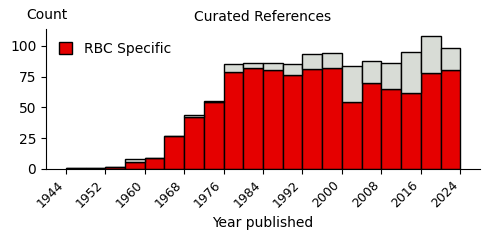

In [15]:
interval, shift = 4, 0  # years
fix_range = True
rbc_color = "xkcd:red"
fontsize = 10

df_years = df_erythrocyte["Year"].astype(int)
year_bounds = (df_years.min(), df_years.max())
year_bounds = (
    df_erythrocyte["Year"].astype(int).min(),
    df_erythrocyte["Year"].astype(int).max(),
)
print(f"Year range:\t {year_bounds}")
if fix_range:
    year_bounds = (
        np.floor_divide(year_bounds[0], interval) * interval + shift,
        np.floor_divide(year_bounds[-1], interval) * interval  + shift,
    )
    print(f"Via intervals:\t {year_bounds}")

# Plot histogram
fig, ax = plt.subplots(1, 1, figsize=(5, 2.5))
sns.despine(fig)
# RBC specific
years_rbc = df_erythrocyte[df_erythrocyte[rbc_specific_key]]["Year"].values.astype(int)

# Not RBC specific
years_other = df_erythrocyte[~df_erythrocyte[rbc_specific_key]]["Year"].values.astype(
    int
)
nbins = int((year_bounds[-1] - year_bounds[0]) / interval)
rects = ax.hist(
    [years_rbc, years_other],
    bins=nbins,
    range=year_bounds,
    stacked=True,
    color=[rbc_color, "xkcd:light gray"],
    edgecolor="black",
)
ax.set_xlabel("Year published", fontdict={"size": fontsize})
ax.set_ylabel("Count", fontdict={"size": fontsize}, loc="top", rotation=0)
ax.set_title("Curated References", fontdict={"size": fontsize})

xticks = np.linspace(year_bounds[0], year_bounds[1], int(nbins / 2) + 1)
ax.set_xticks(
    xticks,
    labels=[str(int(x)) for x in xticks],
    rotation=45,
    ha="right",
    fontsize=fontsize - 1,
)
ax.yaxis.set_label_coords(0.05, 1.05)

ax.legend(
    handles=[mpl.patches.Patch(edgecolor="black", facecolor=rbc_color)],
    labels=[rbc_specific_key],
    frameon=False,
    handleheight=1,
    handlelength=1,
    fontsize=fontsize,
    loc="upper left",
)
fig.tight_layout()
if overwrite:
    fig.savefig(
        f"{ROOT_PATH}{RESULTS_PATH}/{annotation_key}_Histogram.{imagetype}",
        transparent=transparent,
    )
fig;